In [80]:
import os
print(os.getcwd())  # check local
import scipy.optimize
import xarray as xr
import pandas as pd
import numpy as np
import cartopy.mpl.ticker as cticker
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import metpy
import scipy.stats as sts
from glob import glob
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import re
import warnings
import isca_tools
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig
from isca_tools.utils import area_weighting, set_attrs
from isca_tools.utils.base import round_any
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.convection.base import lcl_metpy, dry_profile_temp, moist_profile
from isca_tools.thesis.lapse_theory import get_bulk_lapse_rate, reconstruct_temp, interp_var_at_pressure
from isca_tools.utils.moist_physics import sphum_sat, sphum_from_dew, moist_static_energy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from statsmodels.stats.multitest import fdrcorrection
from tqdm.notebook import tqdm
import scipy
from geocat.comp.interpolation import interp_hybrid_to_pressure
import copy
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/joshduffield/Documents/StAndrews/Isca/jobs/theory_lapse


In [2]:
# Figure formatting
SMALL_SIZE = 5
MEDIUM_SIZE = 6
BIGGER_SIZE = 7


plt.rc('axes', linewidth=0.5)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

## Save Hot day dataset
Save information for hottest 5% of days at each coordinate. Include all data required to do SQE decomposition of what sets variation in temperature spatially.

In [81]:
exp_dir = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/era5/lat40_65_MJJAS_raw'
out_path = os.path.join(exp_dir, 'ds_hot_days.nc')
if not os.path.exists(out_path):
    print(f'No data exists at {out_path}')
    var_file = ['t2m_max', 'd2m', 'sp', 't500', 'z500']
    ds = []
    for i in tqdm(range(len(var_file))):
        ds.append(xr.load_dataset(os.path.join(exp_dir, var_file[i]+'.nc')))
    ds = xr.merge(ds)
else:
    print(f'Loading from {out_path}')
    ds = xr.load_dataset(out_path)

Loading from /Users/joshduffield/Documents/StAndrews/Isca/jobs/era5/lat40_65_MJJAS_raw/ds_hot_days.nc


### Zonal mean 500hPa values
We want to decompose the 500hPa effect into zonal mean values indicating average conditions for that time of year vs. anomaly at a given location, indicating a more circulation effect.

In [4]:
# For 500hPa variables, compute zonal average so later can have anomaly relative to this
# zonal average is computed over all surfaces
if not os.path.exists(out_path):
    ds['t_zonal_av'] = ds.t.mean(dim='longitude')
    ds['z_zonal_av'] = ds.z.mean(dim='longitude')

In [5]:
if not os.path.exists(out_path):
    quant_thresh_all = 0.95         # keep hottest 5% of days throughout entire year
    # convert hottest 5% of entire year into fraction of summer month days to keep i.e. assume all hot days are in summer
    n_keep = (1-quant_thresh_all) * ds.time.size * 365 / np.unique(ds.time.dt.dayofyear).size
    quant_thresh_summer = round_any(1 - n_keep/ds.time.size, 0.01)
    thresh_hot = ds.t2m.quantile(quant_thresh_summer, dim='time')
    is_hot = ds.t2m >= thresh_hot

### Output data
Here we save data as a dataset with a new dimension of `sample`, so we record all the hot days at a given location.

In [6]:
if not os.path.exists(out_path):
    n_days_save = int(is_hot.sum(dim='time').max())
    output_info = {key: np.full((ds.latitude.size, ds.longitude.size, n_days_save), np.nan) for key in ds}
    output_info['time'] = np.full((ds.latitude.size, ds.longitude.size, n_days_save), np.nan, dtype=ds.time.dtype)       # record time of hot days
    for i in tqdm(range(ds.latitude.size)):
        for j in range(ds.longitude.size):
            ind_time_use = np.where(is_hot.isel(latitude=i, longitude=j))[0]        # indices of hot days at this location
            output_info['time'][i, j, :len(ind_time_use)] = ds.time.isel(time=ind_time_use)
            for key in ds:
                if 'zonal_av' in key:
                    output_info[key][i, j, :len(ind_time_use)] = ds[key].isel(latitude=i, time=ind_time_use).squeeze()
                else:
                    # Account for fact that number of days to save can be different at different locations
                    output_info[key][i, j, :len(ind_time_use)] = ds[key].isel(latitude=i, longitude=j, time=ind_time_use).squeeze()
    # Info for converting numpy arrays to
    output_dims = ['latitude', 'longitude', 'sample']
    coords = {'latitude': ds.latitude, 'longitude': ds.longitude, 'sample': np.arange(n_days_save)}
    output_attrs = {'long_name': {}, 'units': {}, 'standard_name': {}}
    for var in output_info:
        output_attrs['long_name'][var] = ds[var].long_name if 'long_name' in ds[var].attrs else ''
        output_attrs['units'][var] = ds[var].units if 'units' in ds[var].attrs else ''
        output_attrs['standard_name'][var] = ds[var].standard_name if 'standard_name' in ds[var].attrs else ''

In [7]:
# Convert output dict into xarray dataset
# Convert individual arrays
if not os.path.exists(out_path):
    for var in output_info:
        output_info[var] = xr.DataArray(output_info[var], dims=output_dims,
                                        coords={key: coords[key] for key in coords})
        output_info[var] = isca_tools.utils.set_attrs(output_info[var], long_name=output_attrs['long_name'][var],
                                                      units=output_attrs['units'][var], standard_name=output_attrs['standard_name'][var])
        if 'pressure_level' in ds[var].dims:
            output_info[var] = output_info[var].expand_dims(pressure_level=np.atleast_1d(ds.coords['pressure_level']))
        if var != 'time':
            output_info[var] = output_info[var].astype('float32')

In [8]:
if not os.path.exists(out_path):
    ds_out = xr.Dataset(output_info)
    ds_out = ds_out.expand_dims(quant=[quant_thresh_summer])           # add quant as a coordinate
    if "units" in ds_out.time.attrs:
        ds_out.time.attrs.pop("units")              # get error if time has attribute of units when saving
    comp_level = 4
    ds_out.to_netcdf(out_path, encoding={var: {"zlib": True, "complevel": comp_level} for var in ds_out.data_vars})

In [82]:
# Land masks
# The year for the land-sea mask matters. Not surprising due to glaciers melting. Zhang used 1979 mask.
dir_invariant = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/era5/invariants'
lsm = xr.open_dataset(os.path.join(dir_invariant, 'lsm1979.nc')).reindex_like(ds)
lsm = lsm.load()
land = lsm.lsm>0
z2m = xr.load_dataset(os.path.join(dir_invariant, 'z1979.nc')).reindex_like(ds)
ds['z2m'] = z2m.z.load().drop_vars('time')       # geopotential so is gz
# Convert to height coordinates all z variables
for var in ['z', 'z2m', 'z_zonal_av']:
    ds[var] = ds[var] / g
    ds[var] = set_attrs(ds[var], True, units='m')

In [94]:
# physical variables
ds['q2m'] = sphum_from_dew(ds.d2m, ds.sp)
ds['rh_2m'] = ds['q2m'] / sphum_sat(ds.t2m, ds.sp)
ds['t_zonal_anom'] = ds.t - ds.t_zonal_av
ds['z_zonal_anom'] = ds.z - ds.z_zonal_av

# Moist static energy variables
ds['mse_2m'] = moist_static_energy(ds.t2m, ds.q2m, ds.z2m)
ds['mse_sat'] = moist_static_energy(ds.t, sphum_sat(ds.t, ds.pressure_level*100), ds.z)

# Effective variables such that CAPE at 500hPa is zero
ds['q2m_eff'] = ds['q2m'] - (ds.mse_2m - ds.mse_sat.isel(pressure_level=0)) * 1000 / L_v
ds['rh_2m_eff'] = ds['q2m_eff'] / sphum_sat(ds.t2m, ds.sp)
ds['rh_2m_eff_diff'] = ds['rh_2m_eff'] - ds['rh_2m']

In [31]:
def initialize_ax_projection(ax, lon_min=-180, lon_max=180, lat_min=30, lat_max=80,
                             grid_lon=np.arange(-180,180.01,60), grid_lat=np.asarray([40, 65])):
    ax.coastlines(color='k', linewidth=1)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    gl = ax.gridlines(ccrs.PlateCarree(), xlocs=grid_lon, ylocs=grid_lat, linestyle=':',
                      color='k', alpha=1, draw_labels=True)
    gl.right_labels=0
    gl.top_labels=0
    return ax

def plot_contour_projection(ax, var, levels=None, n_levels=10, mask=land, cmap='viridis'):
    data, lon = add_cyclic_point(var * (1 if mask is None else mask), coord=var.longitude.values, axis=1)
    if levels is None:
        levels = np.linspace(var.min(), var.max(), n_levels)
    im = ax.contourf(lon, var.latitude.values, data, transform=ccrs.PlateCarree(),
                     levels=levels, extend='both', cmap=cmap)
    return im

In [57]:
def get_var_av(var, n_lat_av=30, mask=land):
    n_pad = n_lat_av // 2  # half window size
    # Pad edge with same values so can take average over latitude
    var_padded = (var.mean(dim="sample").where(mask).median(dim="longitude").pad(latitude=(n_pad, n_pad), mode="edge"))
    var_av = (var_padded.rolling(latitude=n_lat_av, center=True).median(dim="latitude"))
    var_av = var_av.isel(latitude=slice(n_pad, -n_pad))         # only return latitudes kept all along
    return var_av
ds_av = get_var_av(ds)
ds_anom = ds.where(land) - ds_av
# get_var_anom(ds, norm_n_lat, mask=mask).sel(lat=slice(lat_min, lat_max))

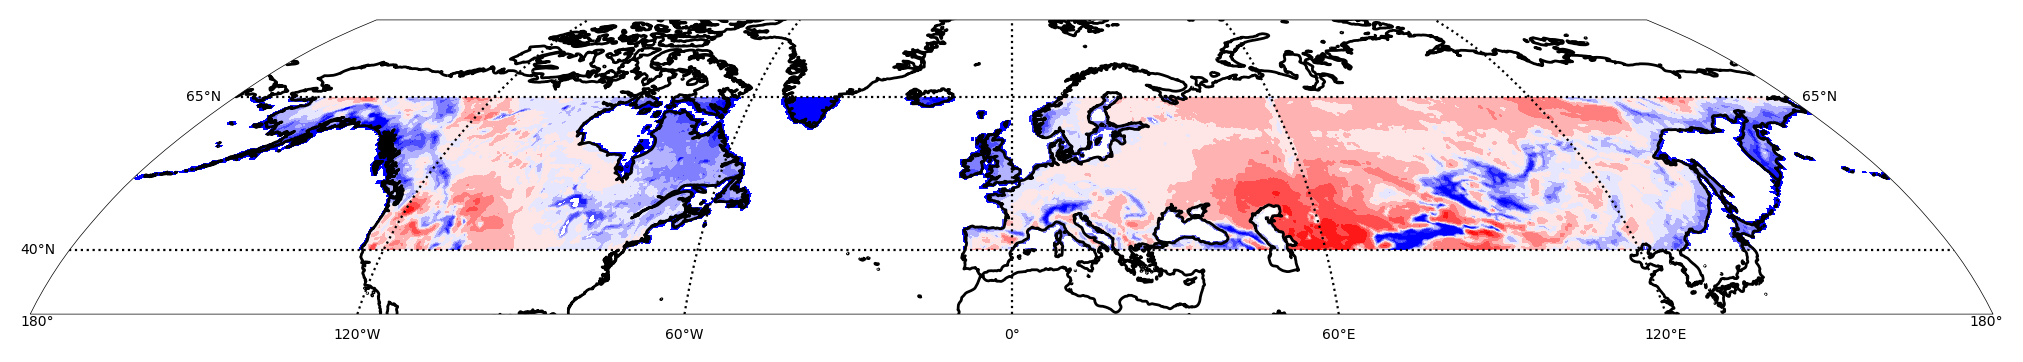

In [64]:
fig = plt.figure(constrained_layout=True)
ax = fig.subplots(1, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
fig_resize(fig, 10)
initialize_ax_projection(ax)
plot_contour_projection(ax, ds_anom.t2m.mean(dim='sample').isel(quant=0), cmap='bwr', levels=np.linspace(-10, 10, 11))
plt.show()